Compiling model...
'compile' took 0.000177 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [3.85e-02, 7.88e-01, 2.69e-01]    [3.76e-02, 7.88e-01, 2.69e-01]    []  
1000      [3.29e-04, 4.74e-04, 6.50e-03]    [3.16e-04, 4.84e-04, 6.50e-03]    []  
2000      [7.21e-05, 1.09e-06, 6.19e-05]    [7.03e-05, 6.68e-07, 6.19e-05]    []  
3000      [2.60e-05, 2.66e-07, 1.31e-05]    [2.57e-05, 2.48e-07, 1.31e-05]    []  
4000      [1.19e-05, 1.15e-05, 1.11e-05]    [1.22e-05, 9.02e-06, 1.06e-05]    []  
5000      [6.46e-06, 1.62e-06, 6.05e-06]    [6.68e-06, 2.67e-06, 6.63e-06]    []  
6000      [4.42e-06, 1.18e-07, 5.28e-06]    [4.64e-06, 1.29e-07, 5.32e-06]    []  
7000      [2.89e-06, 1.07e-07, 3.90e-06]    [2.97e-06, 2.26e-07, 3.93e-06]    []  
8000      [2.02e-06, 8.44e-08, 3.03e-06]    [2.04e-06, 1.49e-07, 3.10e-06]    []  
9000      [1.44e-06, 2.50e-06, 4.78e-06]    [1.45e-06, 4.31e-06, 5.02e-06]    []  
10000     [1.08

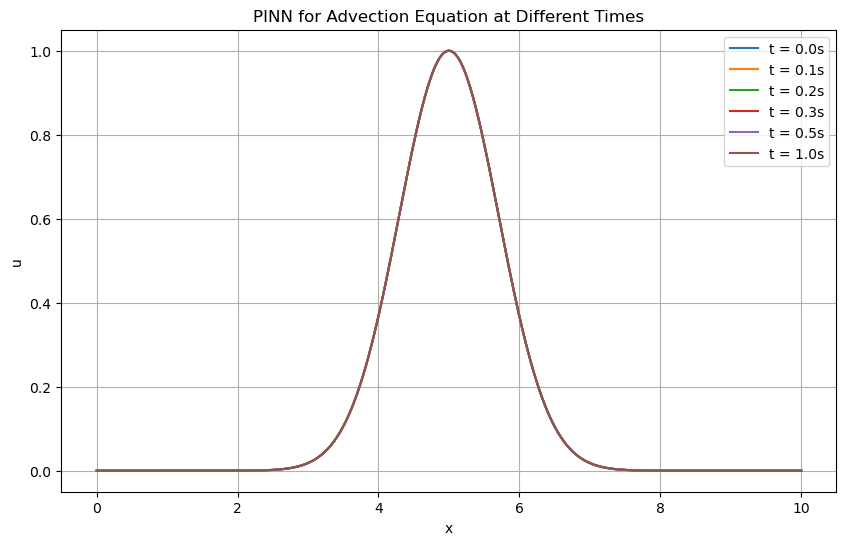

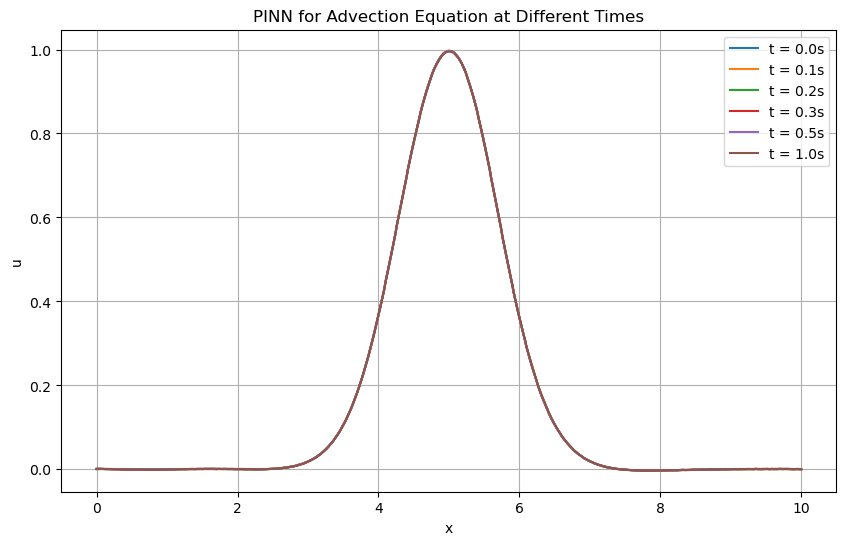

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import deepxde as dde
from deepxde.backend import tf

# 定義常數
c = 0.0001
L = 10.0
num_points = 501
total_time = 101
dt = 0.01
x = np.linspace(0, L, num_points)
u_0 = np.exp(-((x - L / 2) ** 2) / (0.1 * L))

# 定義一維平流方程的真解（FDM解）
def true_solution(t, x):
    u = np.zeros_like(x)
    for i in range(len(x)):
        u[i] = np.exp(-((x[i] - L / 2 - c * t) ** 2) / (0.1 * L))
    return u

# 定義一維平流方程的PDE
def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    return dy_t + c * dy_x

# 定義邊界條件（週期邊界條件）
def boundary(x, on_boundary):
    return on_boundary

# 初始化DeepXDE問題
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, total_time * dt)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# 定義初始條件
def init_func(x):
    return np.exp(-((x[:, 0:1] - L / 2) ** 2) / (0.1 * L))

ic = dde.IC(geomtime, init_func, lambda _, on_initial: on_initial)

# 定義週期邊界條件
bc = dde.PeriodicBC(geomtime, boundary, component=0, on_boundary=boundary)

# 設定數據點和數據集
data = dde.data.TimePDE(geomtime, pde, [bc, ic], num_domain=4000, num_boundary=100, num_initial=1000, num_test=1000)

# 定義神經網絡
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# 定義模型
model = dde.Model(data, net)

# 設定模型訓練
model.compile("adam", lr=1e-3)

# 訓練模型
losshistory, train_state = model.train(epochs=10000)

# 繪製結果
time_steps = [0, 10, 20, 30, 50, 100]
x_test = np.linspace(0, L, num_points).reshape(-1, 1)

# Helper function for plotting
def plot_results(x, solutions, times):
    plt.figure(figsize=(10, 6))
    for sol, time in zip(solutions, times):
        plt.plot(x, sol, label=f't = {int(time*100)}s')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.legend()
    plt.grid(True)
    plt.title('PINN for Advection Equation at Different Times')
    plt.show()

# 計算每個時間步的預測和真實解
solutions = []
for t in time_steps:
    t_test = np.full((num_points, 1), t * dt)
    X_test = np.hstack((x_test, t_test))
    y_pred = model.predict(X_test)
    y_true = true_solution(t * dt, x)
    solutions.append((y_true, y_pred))

# 分別提取真實解和PINN預測解
true_solutions = [sol[0] for sol in solutions]
pinn_solutions = [sol[1] for sol in solutions]

# 繪製結果
plot_results(x, pinn_solutions, [t * dt for t in time_steps])

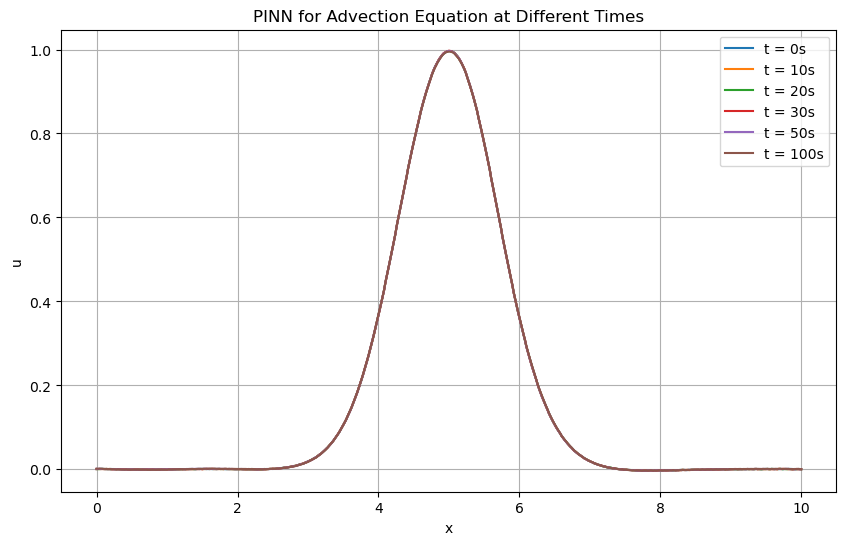

In [29]:
# 繪製結果
time_steps = [0, 10, 20, 30, 50, 100]
x_test = np.linspace(0, L, num_points).reshape(-1, 1)

# Helper function for plotting
def plot_results(x, solutions, times):
    plt.figure(figsize=(10, 6))
    for sol, time in zip(solutions, times):
        plt.plot(x, sol, label=f't = {int(time*100)}s')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.legend()
    plt.grid(True)
    plt.title('PINN for Advection Equation at Different Times')
    plt.show()

# 計算每個時間步的預測和真實解
solutions = []
for t in time_steps:
    t_test = np.full((num_points, 1), t * dt)
    X_test = np.hstack((x_test, t_test))
    y_pred = model.predict(X_test)
    y_true = true_solution(t * dt, x)
    solutions.append((y_true, y_pred))

# 分別提取真實解和PINN預測解
true_solutions = [sol[0] for sol in solutions]
pinn_solutions = [sol[1] for sol in solutions]

# 繪製結果
plot_results(x, pinn_solutions, [t * dt for t in time_steps])


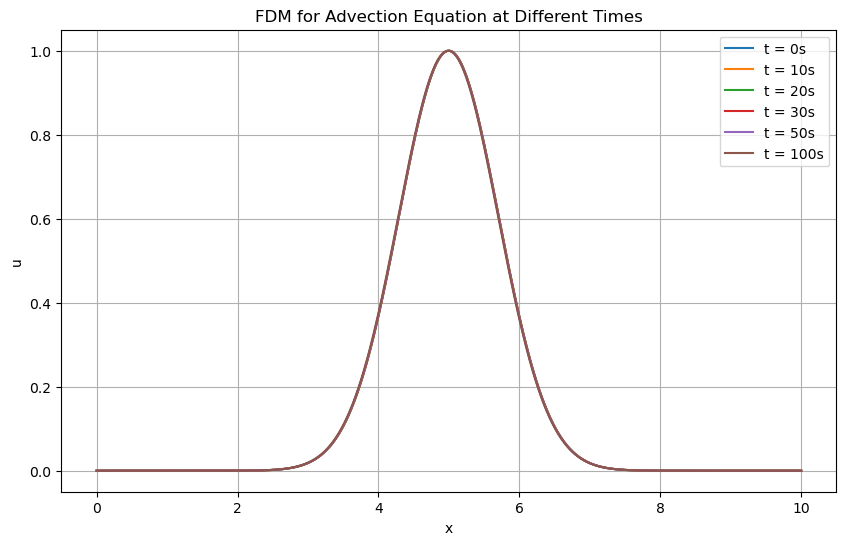

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Define the computational domain and mesh resolution
L = 10.0
num_points = 501
dx = L / num_points
x = np.linspace(0, L, num_points)
dt = 0.01
c = 0.0001  # Advection speed
total_time = 101  # Total simulation time in seconds
num_steps = int(total_time / dt)

# Initial condition: Gaussian pulse
u0 = np.exp(-((x - L/2) ** 2) / (0.1 * L))

# Helper function for plotting
def plot_results(x, solutions, times):
    plt.figure(figsize=(10, 6))
    for sol, time in zip(solutions, times):
        plt.plot(x, sol, label=f't = {time}s')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.legend()
    plt.grid(True)
    plt.title('FDM for Advection Equation at Different Times')
    plt.show()

# Finite Difference Method (FDM) with periodic boundary conditions
def solve_fdm_periodic(u0, c, dx, dt, num_steps, times):
    u = u0.copy()
    results = []
    for i in range(num_steps):
        u[:-1] = u[:-1] - c * dt / dx * (u[:-1] - np.roll(u, -1)[:-1])
        u[-1] = u[-1] - c * dt / dx * (u[-1] - u[0])  # Handling the last point
        current_time = dt * i
        if current_time in times:
            results.append(u.copy())
    return results


# Times at which to record the solution
times = [0, 10, 20, 30, 50, 100]

# Solve the advection equation using each method
u_fdm = solve_fdm_periodic(u0, c, dx, dt, num_steps, times)


# Plot results for FDM
plot_results(x, u_fdm, times)

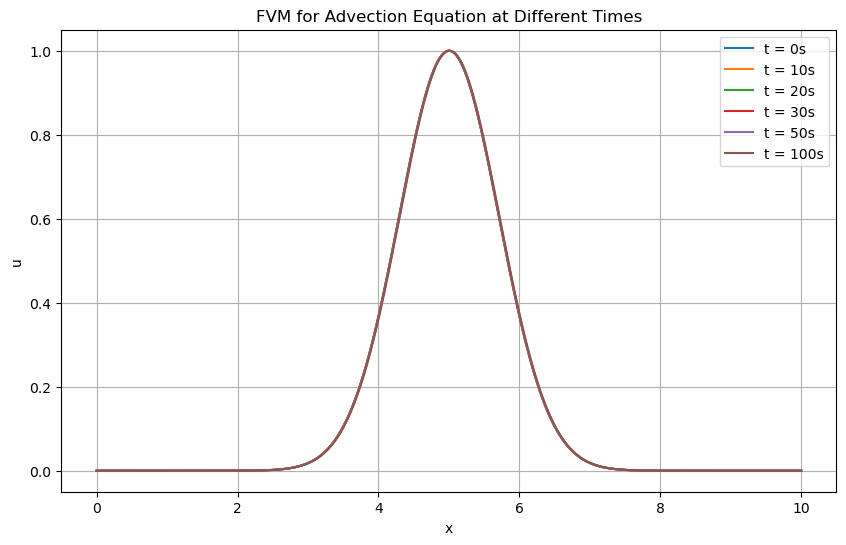

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Define the computational domain and mesh resolution
L = 10.0
num_points = 501
dx = L / num_points
x = np.linspace(0, L, num_points)
dt = 0.01
c = 0.0001  # Advection speed
total_time = 101  # Total simulation time in seconds
num_steps = int(total_time / dt)

# Initial condition: Gaussian pulse
u0 = np.exp(-((x - L/2) ** 2) / (0.1 * L))

# Helper function for plotting
def plot_results(x, solutions, times):
    plt.figure(figsize=(10, 6))
    for sol, time in zip(solutions, times):
        plt.plot(x, sol, label=f't = {time}s')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.legend()
    plt.grid(True)
    plt.title('FVM for Advection Equation at Different Times')
    plt.show()

# Finite Difference Method (FDM) with periodic boundary conditions
def solve_fvm_periodic(u0, c, dx, dt, num_steps, times):
    u = u0.copy()
    results = []
    for i in range(num_steps):
        flux = c * u
        u[:-1] = u[:-1] - dt / dx * (flux[1:] - flux[:-1])
        u[-1] = u[-1] - dt / dx * (flux[0] - flux[-1])  # Wrapping around
        current_time = dt * i
        if current_time in times:
            results.append(u.copy())
    return results


# Times at which to record the solution
times = [0, 10, 20, 30, 50, 100]

# Solve the advection equation using each method
u_fvm = solve_fvm_periodic(u0, c, dx, dt, num_steps, times)


# Plot results for FDM
plot_results(x, u_fvm, times)



Text(0.5, 1.0, 'FDM-FVM for Advection Equation at Different Times')

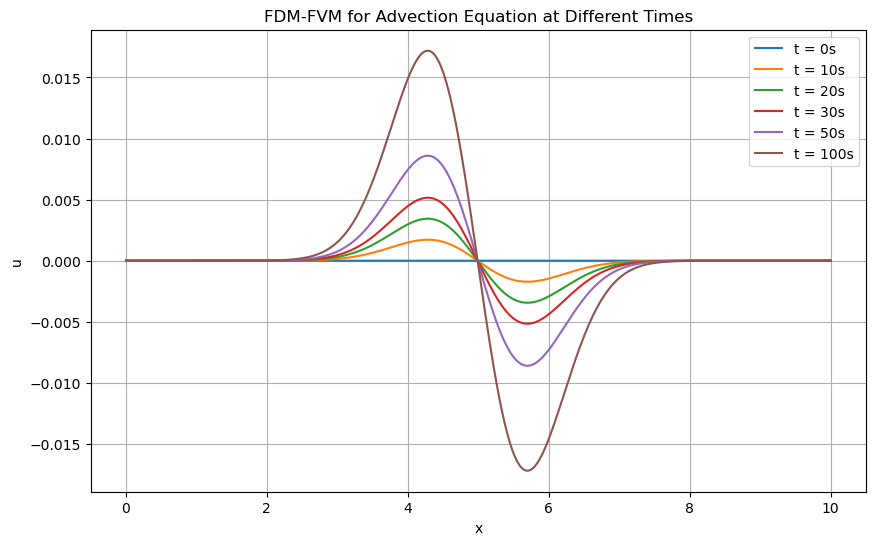

In [32]:
plt.figure(figsize=(10, 6))
for i in range(len(u_fdm)):
    plt.plot(x, u_fdm[i]-u_fvm[i], label=f't = {times[i]}s')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid(True)
plt.title('FDM-FVM for Advection Equation at Different Times')


In [33]:
pinn_solutions.shape, u_fdm.shape, u_fvm.shape

AttributeError: 'list' object has no attribute 'shape'

In [37]:
pinn_arr = np.array(pinn_solutions)
print(pinn_arr.shape)
pinn_arr = pinn_arr.reshape(6, 501)
print(pinn_arr.shape)

(6, 501, 1)
(6, 501)


In [36]:
u_fdm_arr = np.array(u_fdm)
u_fdm_arr.shape

(6, 501)

In [38]:
u_fvm_arr = np.array(u_fvm)
u_fvm_arr.shape

(6, 501)

Text(0.5, 1.0, 'FDM-PINN for Advection Equation at Different Times')

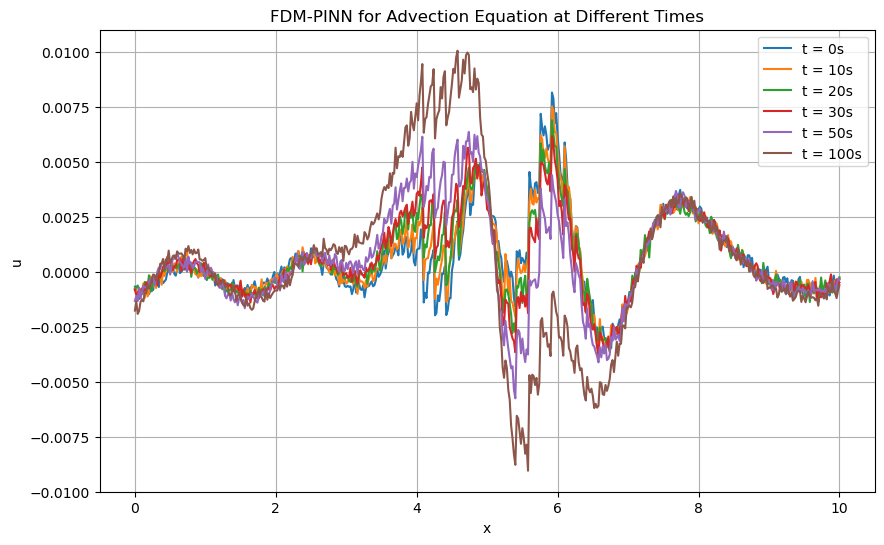

In [41]:
plt.figure(figsize=(10, 6))
for i in range(len(u_fdm)):
    plt.plot(x, u_fdm_arr[i]-pinn_arr[i], label=f't = {times[i]}s')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid(True)
plt.title('FDM-PINN for Advection Equation at Different Times')

Text(0.5, 1.0, 'FVM-PINN for Advection Equation at Different Times')

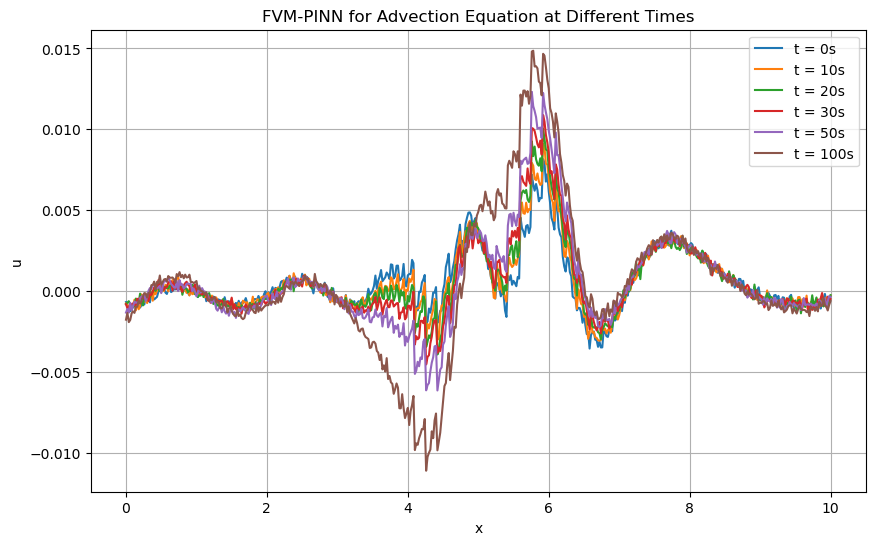

In [40]:
plt.figure(figsize=(10, 6))
for i in range(len(u_fdm)):
    plt.plot(x, u_fvm_arr[i]-pinn_arr[i], label=f't = {times[i]}s')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.title('FVM-PINN for Advection Equation at Different Times')

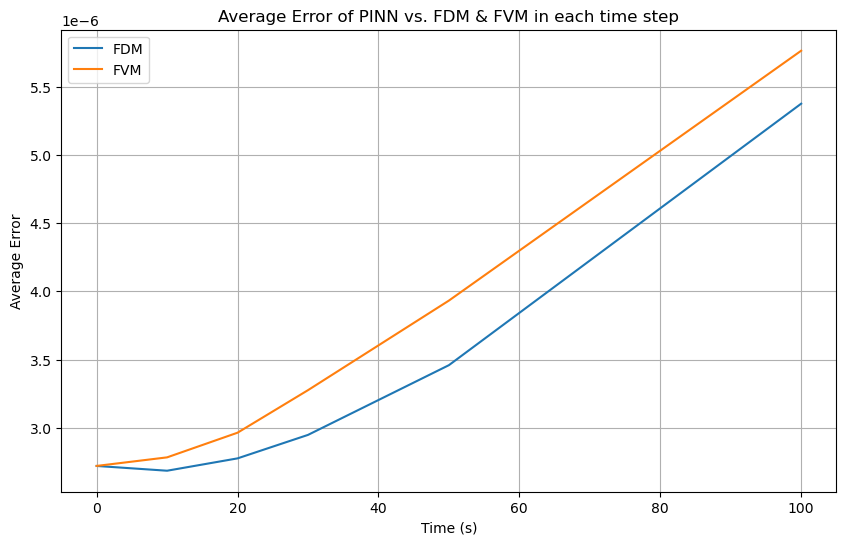

In [44]:
# Calulate the average error 
def relative_error(true, pred):
    return np.mean(np.abs(true - pred) / len(true))

# Calculate the average relative error for each time step  
errors_fdm = [relative_error(true, pred) for true, pred in zip(u_fdm_arr, pinn_arr)]
errors_fvm = [relative_error(true, pred) for true, pred in zip(u_fvm_arr, pinn_arr)]

# Plot the average relative error for each time step
plt.figure(figsize=(10, 6))
plt.plot(times, errors_fdm, label='FDM')
plt.plot(times, errors_fvm, label='FVM')
plt.xlabel('Time (s)')
plt.ylabel('Average Error')
plt.legend()
plt.grid(True)
plt.title('Average Error of PINN vs. FDM & FVM in each time step')
plt.show()